In [ ]:
# TODO Currently accesses .pos files from local directory. Must change to download from Zenodo when available
# PUT WHAT VERSION THE PAPER WAS RUN WITH!

# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Make and save the catalog of Whillans Stick Slip Events from .pos files, 
available from Earthscope at LINK. Keep the .pos files in the same folder
structure they were downloaded as, and set the top level directory as the
variable dir below.

v1.0 01 November 2024
    Clean catalog creation using Catalog.py
    Outputs Events, EventStartTimes, and NoData folders
"""

# Imports
import os
import logging

import src.Catalog.Catalog as Catalog

# %load_ext line_profiler


################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]

year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [["2019"]]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 1 # Minimum number of stations needed for an event
hr_off = 0 # Offset for hours on either side of threshold to save [hours]

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 

# fmt: on
########################## User Defined Variables ##############################
################################################################################


# Helper functions
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [ ]:
# Make Catalog

# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)
    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()
    no_data = picks.no_data_csv(min_stas, sorted_list)

    merged_df = picks.merge()
    merged = Catalog.Events(merged_df)
    threshold = merged.pick_events(sorted_list, active_stas=min_stas, hr_off=hr_off)

    catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)
    save_dir = f"./Events{min_stas}stas/{years[0]}_{years[-1]}Events{min_stas}stas"
    Catalog.save_catalog(catalog, save_dir)

    start_time_save = f"./EventStartTime{min_stas}stas"
    name = f"{years[0]}EventStartTime{min_stas}stas"
    folders = [f"./Events{min_stas}stas/{years[0]}_{years[-1]}Events{min_stas}stas"]
    Catalog.event_start_time(folders, start_time_save, name)

2024-11-01 12:06:54 __main__ INFO: Creating Dataframe for la01
2024-11-01 12:06:54 __main__ INFO: Interpolating la01
2024-11-01 12:06:55 __main__ INFO: Creating Dataframe for la02
2024-11-01 12:07:03 __main__ INFO: Interpolating la02
2024-11-01 12:07:04 src.Catalog.Catalog INFO: 2019-01-12 04:03:00 2019-01-12 04:05:00 0 days 00:02:00
2024-11-01 12:07:06 src.Catalog.Catalog INFO: 2019-02-08 16:33:00 2019-02-08 16:35:00 0 days 00:02:00
2024-11-01 12:07:10 src.Catalog.Catalog INFO: 2019-03-22 14:51:00 2019-03-22 14:53:00 0 days 00:02:00
2024-11-01 12:07:12 src.Catalog.Catalog INFO: 2019-04-11 09:32:45 2019-04-11 09:34:45 0 days 00:02:00
2024-11-01 12:07:12 src.Catalog.Catalog INFO: 2019-04-16 19:59:45 2019-04-16 20:00:30 0 days 00:00:45
2024-11-01 12:07:13 src.Catalog.Catalog INFO: 2019-04-27 09:46:15 2019-04-27 09:48:15 0 days 00:02:00
2024-11-01 12:07:17 __main__ INFO: Creating Dataframe for la03
2024-11-01 12:07:17 __main__ INFO: Interpolating la03
2024-11-01 12:07:17 __main__ INFO: Cr

In [4]:
# Combine all start times into one text file
text_files = [
    f"./EventStartTime{min_stas}stas/{year[0]}EventStartTime{min_stas}stas.txt"
    for year in year_arr
]
outfile = f"AllEventStartTimes{min_stas}stas.txt"

# Read in all text files and remove 1st line
with open(outfile, "w") as out_file:
    out_file.write("EventStartTime\n")
    for file in text_files:
        with open(file, "r") as in_file:
            in_file.readline()
            for line in in_file:
                out_file.write(line)

# Combine all no data files into one text file
text_files = [
    f"NoData{min_stas}stas/{year[0]}-{year[0]}no_data_{min_stas}sta.txt"
    for year in year_arr
]
outfile = f"no_data{min_stas}stas.txt"

# Read in all text files and remove 1st line
with open(outfile, "w") as out_file:
    out_file.write("start\tend\n")
    for file in text_files:
        with open(file, "r") as in_file:
            in_file.readline()
            for line in in_file:
                out_file.write(line)

203


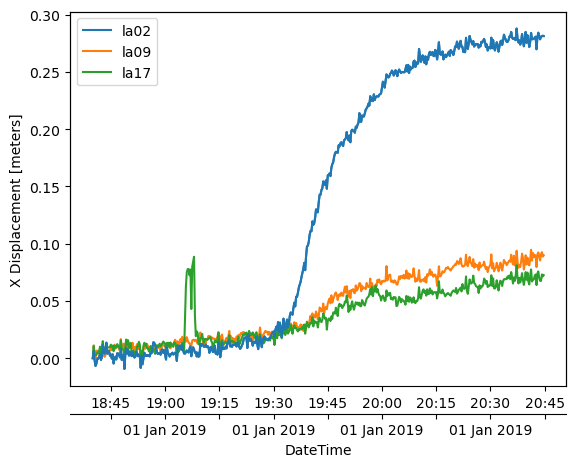

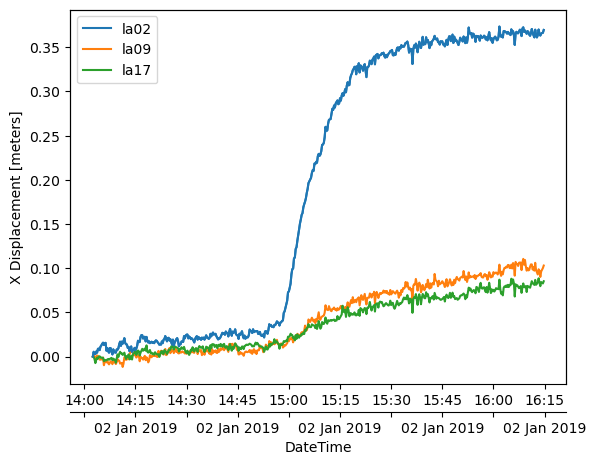

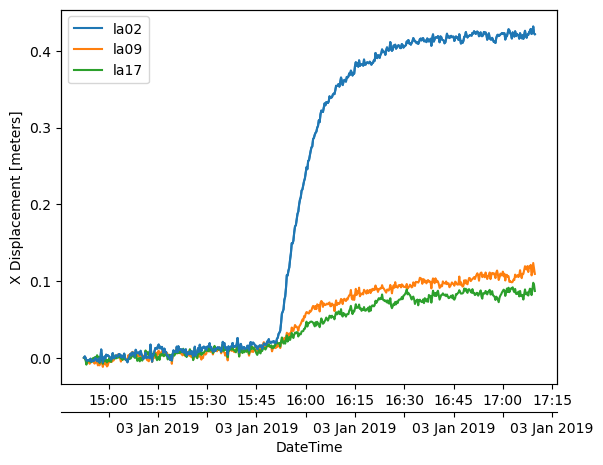

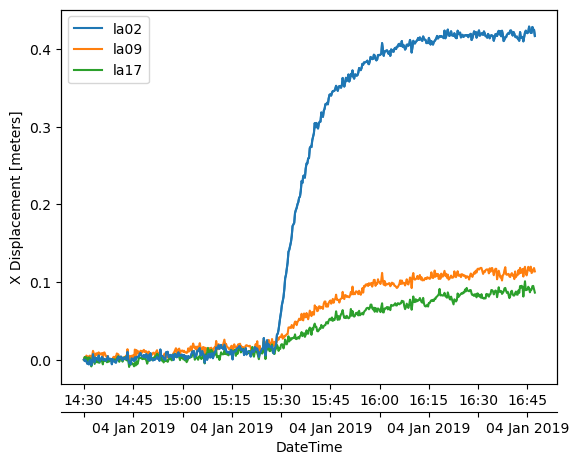

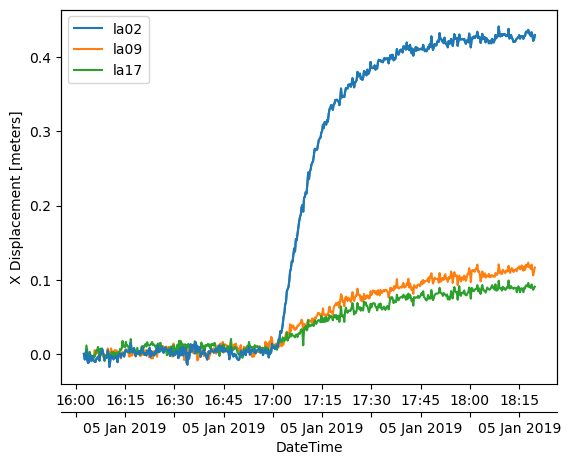

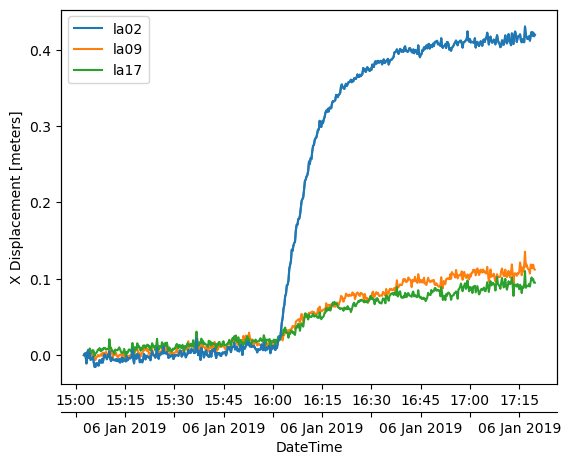

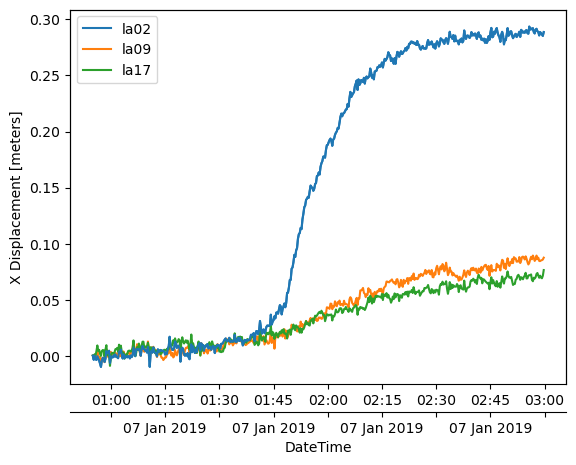

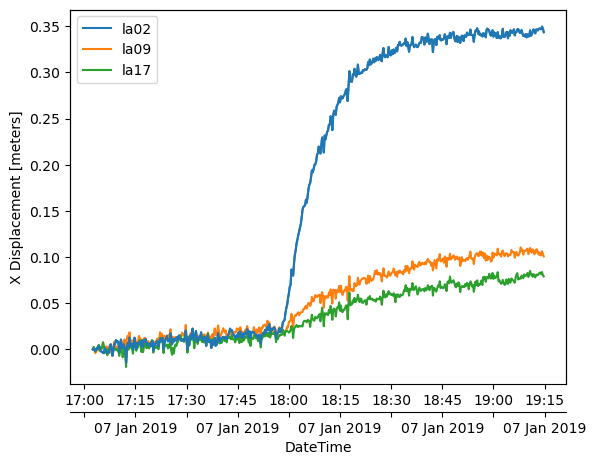

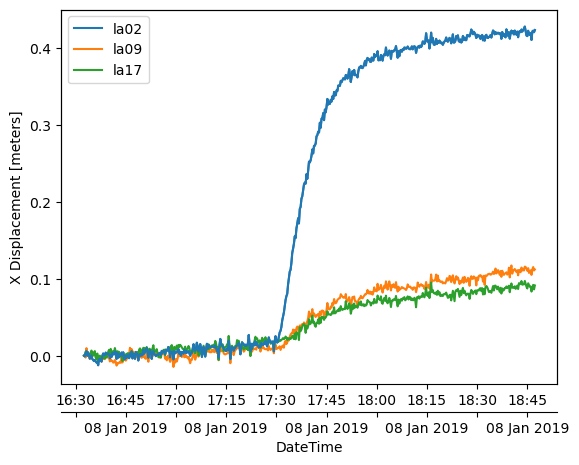

In [5]:
# Plot Example Events
start_event = 1
end_evnet = 10
print(len(catalog))
for event in catalog[start_event:end_evnet]:
    Catalog.plot_event(event)